# Analyzing the MDA trajectory

Particularly, compare the contributions with the coulomb potential.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import schnetpack as sp
import numpy as np

from copy import copy

import torch, numpy
import matplotlib.pyplot as plt

from symbxai.lrp.symbolic_xai import SchNetSymbXAI

from tqdm import tqdm

from numpy import genfromtxt


/opt/homebrew/Caskroom/miniconda/base/envs/symbxai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# A few global variables
atom_names_dict = {1: "H", 6: "C", 7: "N", 8: "O", 9: "F"}
models = {}
datasets = {}
target_props = {}
cutoff = {}
kcal2eV_scal=23.060541945329334

# Load MDA Model

In [4]:
mdamodel_file = '../saved_models/mda_schnorb_model_v2/best_model'
mdamodel = torch.load(mdamodel_file, map_location=torch.device('cpu'))
cutoff['mda'] = mdamodel.representation.cutoff_fn.cutoff.item()
# qm9model.do_postprocessing = False
models['mda'] = mdamodel

target_props['mda'] = 'energy'

# models['qm9'](copy(datasets['mda'][0]))


# Load the Data - MDA Trajectory

In [5]:
from ase.io import read

from schnetpack.interfaces.ase_interface import AtomsConverter

ats = read('data/mda_extracted_88300_88800.xyz', index=":")

converter = AtomsConverter(neighbor_list=sp.transform.ASENeighborList(cutoff=cutoff['mda']),
        device="cpu",
        dtype=torch.float32
    )

mdatraj = [converter(at) for at in ats]

datasets['mdatraj'] = mdatraj

# Load MDA in equilibrium state

In [6]:
from ase.io import read

from schnetpack.interfaces.ase_interface import AtomsConverter

ats = read('data/equi_mda.extxyz', index=":")

converter = AtomsConverter(neighbor_list=sp.transform.ASENeighborList(cutoff=cutoff['mda']),
        device="cpu",
        dtype=torch.float32
    )

emda = [converter(at) for at in ats]

datasets['equi_mda'] = emda

# Load the coulomb potential from file

In [7]:
coulomb_all = genfromtxt('data/traj-mda.csv', delimiter=',')
edges = []
for i in range(0, 9):
    for j in range(i+1, 9):
        edges.append((i,j))

assert len(edges) == coulomb_all.shape[0]

coulomb_all = {edge: coul for edge, coul in zip(edges, coulomb_all)}


# Experiment 1 - Visualize third order queries

In [8]:
gamma = 0.

contr = {}
query_modes = [ 'O$_l \\wedge $H$ \\wedge $O$_r$', 
               'O$_l \\wedge $H$ \\wedge \\neg $O$_r$', 
               'O$_l \\wedge $C$ \\wedge $H', 
               'O$_l \\wedge $H$ \\wedge \\neg $C', 
               'O$_l \\wedge $C$ \\wedge \\neg $H', 
               'O$_l \\wedge $H', 
               'O$_l \\wedge $C']



# edges = [
# #     (1,7), (2,8), # CH (0,6), 
#     (1,3), (2,4), # CO
#     (4,5), (3,5), # OH
# #     (0,2),(0,1)  # CC
# ]

# clc_contr = {}

# nodes = [
#     1,2,3,4,5
# ]
for model_mode in [ 'mda']:
    contr[model_mode] = {}
    for query_mode in query_modes:
        
        contr[model_mode].update({query_mode : [] })
        # clc_contr[model_mode] = {node : [] for node in nodes}
        
        for sample in tqdm(datasets['mdatraj'], desc=query_mode):
            explainer = SchNetSymbXAI(copy(sample),
                                          models[model_mode], 
                                          target_props[model_mode], 
                                          gamma = gamma,
                                         scal_val = 1/(kcal2eV_scal if model_mode=='md17' else 1))
    
            
            if query_mode == 'O$_l \\wedge $H$ \\wedge $O$_r$':
                # Handle the case for 'O$_l \\wedge $H$ \\wedge $O$_r$'
                query_contr = explainer.symb_and([3,4,5])
            elif query_mode == 'O$_l \\wedge $H$ \\wedge \\neg $O$_r$':
                # Handle the case for 'O$_l \\wedge $H$ \\wedge \\neg $O$_r$'
                query_contr = explainer.symb_and([4,5], context= [node_id for node_id in explainer.node_domain if 3 != node_id ])
            elif query_mode == 'O$_l \\wedge $C$ \\wedge $H':
                # Handle the case for '$O_l \\wedge H \\wedge C$'
                query_contr = explainer.symb_and([2,4,5])
            elif query_mode == 'O$_l \\wedge $H$ \\wedge \\neg $C':
                # Handle the case for 'O$_l \\wedge $H$ \\wedge \\neg $C'
                query_contr = explainer.symb_and([4,5], context= [node_id for node_id in explainer.node_domain if 2 != node_id ])
            elif query_mode == 'O$_l \\wedge $C$ \\wedge \\neg $H':
                # Handle the case for '$O_l \\wedge \\neg H \\wedge C$'
                query_contr = explainer.symb_and([2,4], context= [node_id for node_id in explainer.node_domain if 5 != node_id ])
            elif query_mode == 'O$_l \\wedge $H':
                # Handle the case for 'O$_l \\wedge $H'
                query_contr = explainer.symb_and([4,5])
            elif query_mode == 'O$_l \\wedge $C':
                # Handle the case for 'O$_l \\wedge $C'
                query_contr = explainer.symb_and([2,4])
            else:
                raise NotImplementedError(f"The query_mode '{query_mode}' is not implemented.")
                
            contr[model_mode][query_mode].append( query_contr.item() )
                
                                               

O$_l \wedge $C: 100%|██████████| 501/501 [00:13<00:00, 36.28it/s]


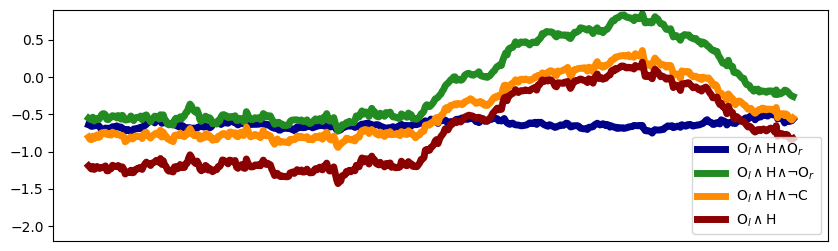

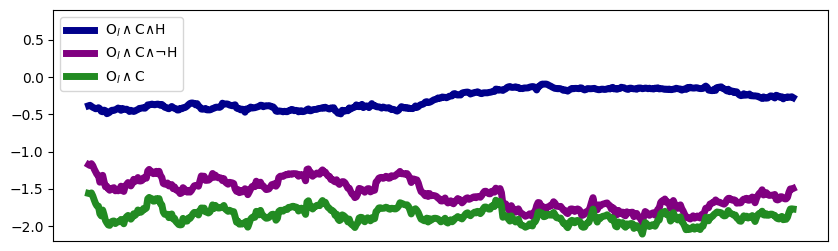

In [10]:
ylims = (-2.2,.9)
plt.figure(figsize=(10,3))
model_mode = 'mda'
colors = {
                'O$_l \\wedge $H$ \\wedge $O$_r$': 'darkblue', 
               'O$_l \\wedge $H$ \\wedge \\neg $O$_r$': 'forestgreen', 
               'O$_l \\wedge $C$ \\wedge $H' : 'darkblue', 
               'O$_l \\wedge $H$ \\wedge \\neg $C': 'darkorange', 
               'O$_l \\wedge $C$ \\wedge \\neg $H': 'purple', 
               'O$_l \\wedge $H': 'darkred', 
               'O$_l \\wedge $C' : 'forestgreen'
}
for query_mode, contr_seq in contr[model_mode].items():
    # print(contr_seq,query_mode)
     if query_mode in [ 'O$_l \\wedge $H$ \\wedge $O$_r$', 
                       'O$_l \\wedge $H$ \\wedge \\neg $O$_r$', 
                       # '$O_l \\wedge H \\wedge C$', 
                       'O$_l \\wedge $H$ \\wedge \\neg $C', 
                       # '$O_l \\wedge C \\neg H$', 
                       'O$_l \\wedge $H', 
                       # 'O$_l \\wedge $C'
                      ]:
        plt.plot(contr_seq, label=query_mode, lw=5, color=colors[query_mode])
# plt.title('$O_l \\wedge H$ queries')
plt.legend()
plt.ylim(*ylims)
plt.xticks([])
# plt.savefig('pics/mda_traj_more_queries_O_H.svg', transparent=True)
plt.show()

plt.figure(figsize=(10,3))
model_mode = 'mda'
for query_mode, contr_seq in contr[model_mode].items():
    # print(contr_seq,query_mode)
    if query_mode in [ 
                        # 'O$_l \\wedge $H$ \\wedge $O$_r$', 
                       # 'O$_l \\wedge $H$ \\wedge \\neg $O$_r$', 
                       'O$_l \\wedge $C$ \\wedge $H', 
                       # 'O$_l \\wedge $H$ \\wedge \\neg $C', 
                       'O$_l \\wedge $C$ \\wedge \\neg $H', 
                       # 'O$_l \\wedge $H', 
                       'O$_l \\wedge $C']:
        plt.plot(contr_seq, label=query_mode, lw=5, color=colors[query_mode])
# plt.title('$O_l \\wedge C$ queries')
plt.ylim(*ylims)
plt.legend()
plt.xticks([])
# plt.savefig('pics/mda_traj_more_queries_C_O.svg', transparent=True)
plt.show()

# Experiment 2 - Visualize edge queries

## Generate all contribution terms

In [11]:
gamma = 0.

contr = {}
query_mode =  'inclusive' # 'exclusive' #
edges = [
#     (1,7), (2,8), # CH (0,6), 
    (1,3), (2,4), # CO
    (4,5), (3,5), # OH
#     (0,2),(0,1)  # CC
]

clc_contr = {}

nodes = [
    1,2,3,4,5
]

for model_mode in ['mda']:
#     vi, vj = np.meshgrid( range(9), range(9))

    contr[model_mode] = {edge : [] for edge in edges}
    clc_contr[model_mode] = {node : [] for node in nodes}
    
    for sample in tqdm(datasets['mdatraj']):
        explainer = SchNetSymbXAI(copy(sample),
                                      models[model_mode], 
                                      target_props[model_mode], 
                                      gamma = gamma,
                                     scal_val = 1/(kcal2eV_scal if model_mode=='md17' else 1))

        for edge in contr[model_mode].keys():
            if query_mode == 'exclusive':
                context = list(edge)
            elif query_mode == 'inclusive':
                context = None
                
            contr[model_mode][edge].append( explainer.symb_and(list(edge), 
                                                  context = context
                                          ).item() )
            
        for node in clc_contr[model_mode].keys():
            clc_contr[model_mode][node].append( explainer.symb_or([node], 
                                                  context=None).item() ) 
                                               

100%|██████████| 501/501 [01:11<00:00,  6.98it/s]


In [12]:
all_dists = {edge: [] for edge in edges }
for sample in tqdm(datasets['mdatraj']):
    for edge in all_dists.keys():
        (i,j) = edge
        all_dists[edge].append(torch.norm(sample['_positions'][i] - sample['_positions'][j]).data)


100%|██████████| 501/501 [00:00<00:00, 35918.61it/s]


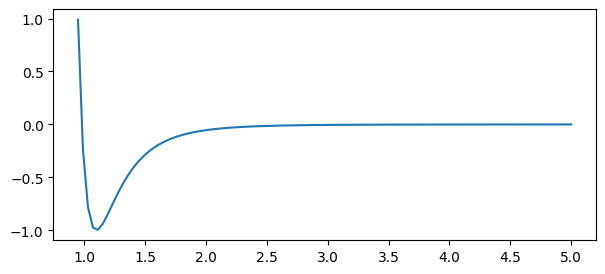

100%|██████████| 501/501 [00:00<00:00, 12596.79it/s]


In [13]:
def lennard_jones(u, u0=1.1, V0=1.):
    return V0*(u0/u)**12 - V0*2*(u0/u)**6

u0 = 1.1
V0 = 1.

u0s = {
    (1,3): 1.26,  # CO
    (2,4): 1.26,  # CO
    (4,5): 1.04, # OH
    (3,5): 1.04 # OH
}
us = numpy.linspace(.95, 5, 100)

ljs = [lennard_jones(u, u0=u0, V0=V0) for u in us]

plt.figure(figsize=(7,3))
plt.plot(us, ljs)
plt.show()

all_lenjones = {edge: [] for edge in edges }
for sample in tqdm(datasets['mdatraj']):
    for edge in all_dists.keys():
        (i,j) = edge
        dst = torch.norm(sample['_positions'][i] - sample['_positions'][j]).data
        all_lenjones[edge].append(lennard_jones(dst, u0=u0s[edge]))


In [14]:
def find_const_approx(vals1, vals2):
    osplit_id, ovleft1, ovright1, ovleft2, ovright2 = 0, float('inf'), float('inf'), float('inf'), float('inf')
    for split_id in range(1,len(vals1)-1):
        left1, right1, left2, right2 = vals1[:split_id], vals1[split_id:], vals2[:split_id], vals2[split_id:]
        vleft1, vright1, vleft2, vright2 = len(left1)*numpy.var(left1), len(right1)*numpy.var(right1), len(left2)*numpy.var(left2), len(right2)*numpy.var(right2)

        if ovleft1+ovright1+ovleft2+ovright2 > vleft1+vright1+vleft2+vright2:
            # found new optimum
            osplit_id, ovleft1, ovright1, ovleft2, ovright2 = split_id, vleft1, vright1, vleft2, vright2
            
    return osplit_id

## visualize the edge contributions

mda


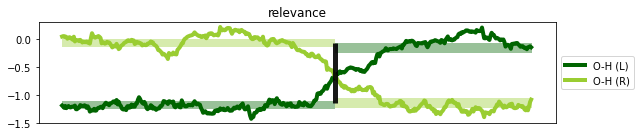

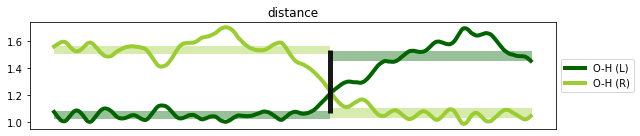

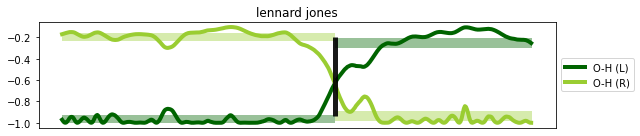

In [ ]:
# plt.rcParams.update({'font.size': 28})

model_mode = 'mda' # 'mda'

interesting_edges = [
#     (1,7), (2,8), # CH (0,6), 
#     (1,3), (2,4), # CO
    (4,5), (3,5), # OH
#     (0,2),(0,1)  # CC
]


heights = {'relevance': .1, 'coulomb': 6, 'distance':  5, 'lennard jones': 5}

colors = {
    (1,3): 'indigo',
    (2,4): 'mediumvioletred',
    (4,5): 'darkgreen',
    (3,5): 'yellowgreen',
    (0,2): 'blue',
    (0,1): 'black',
    (1,7): 'blue',
    (2,8): 'black'
}

max_id = 440
select_inter_edges = True

import itertools
marker = itertools.cycle((',', '+', '.', '*', 'v', 's', 'p')) 
print(model_mode)
for mode, vals in zip(['relevance', 'distance', 'lennard jones'], #  'coulomb', 
                      [contr[model_mode], all_dists, all_lenjones ]): # coulomb_all, all_dists,
    plt.figure(figsize=(9,2))
    for (i,j),rels in vals.items():
        rels = rels[:max_id]
#         if mode == 'relevance':
#             rels = (numpy.array(clc_contr[model_mode][i]) + numpy.array(clc_contr[model_mode][j]))[:max_id]
        
        a1,a2 = atom_names_dict[sample['_atomic_numbers'][i].item()], atom_names_dict[sample['_atomic_numbers'][j].item()]
        if (i,j) == (2,4) or (i,j) == (4,5) :
            label = f'{a1}-{a2} (L)'
        elif (i,j) == (1,3) or (i,j) == (3,5):
            label = f'{a1}-{a2} (R)'
        else:
            label = f'${a1}-{a2}$'
#         if abs(sum(rels)/len(rels))< 0.4: continue

        if select_inter_edges and (i,j) not in interesting_edges: continue
        
        c = colors[(i,j)]
        plt.plot(rels, 
                 label = label,
                 lw = 4,
                 color=c,
#                 marker=next(marker),
                markersize=7)

    
    vals1, vals2 = [vals[edge] for edge in interesting_edges] # [bond_rels[bond] for bond in colors.keys()]
    osplit_id= find_const_approx(vals1[:max_id], vals2[:max_id])
    
#     print(osplit_id)
    maxup, mindown = -float('inf'), float('inf')
    for (i,j) in interesting_edges:
        rels = vals[(i,j)][:max_id]
#         if mode == 'relevance':
#             rels = (numpy.array(clc_contr[model_mode][i]) + numpy.array(clc_contr[model_mode][j]))[:max_id]
        c = colors[(i,j)]
        plt.hlines(numpy.mean(rels[:osplit_id]), 0, osplit_id,
                   color=c, 
                   linewidth=8, alpha=.4)
        plt.hlines(numpy.mean(rels[osplit_id:]), osplit_id, max_id,
                   color=c, 
                   linewidth=10, alpha=.4)

        
    plt.vlines(osplit_id, 
               numpy.mean(rels[:osplit_id]), 
               numpy.mean(rels[osplit_id:]), color='black', lw=5, alpha=.9)

    max_height = max(max(vals1), max(vals2))
    min_height = min(min(vals1), min(vals2))
    margin = (heights[mode] - (max_height - min_height))/2
    plt.xticks([])
#     plt.yticks([])
#     plt.ylim([min_height - margin,max_height+margin])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(mode)
    # plt.legend( loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    a1,a2 = atom_names_dict[sample['_atomic_numbers'][i].item()], atom_names_dict[sample['_atomic_numbers'][j].item()]
    # plt.savefig(f'pics/mda_traj_selected_{query_mode}_contr_{a1}-{a2}_{mode}_model-{model_mode}.png', transparent=True)

    plt.show()

# node contributions

mda


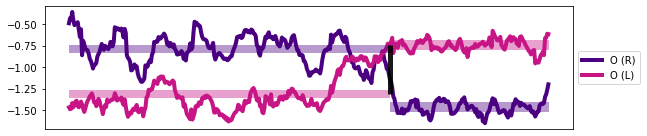

In [ ]:
const_approx = True
interesting_nodes =[
#      1, # C (R)
#      2, # C (L)
     3, # O (R)
     4, # O (L)
#      5  # H 
]

# plt.rcParams.update({'font.size': 28})

model_mode = 'mda' # 'mda'

# heights = {'relevance': .1, 'coulomb': 6, 'distance':  5, 'lennard jones': 5}

colors = {
    3: 'indigo',
    4: 'mediumvioletred',
    1: 'darkgreen',
    2: 'yellowgreen',
    5: 'blue',
#     (0,1): 'black',
#     (1,7): 'blue',
#     (2,8): 'black'
}

max_id = 440
select_inter_edges = True

import itertools
# marker = itertools.cycle((',', '+', '.', '*', 'v', 's', 'p')) 
print(model_mode)
for mode, vals in zip([ 'classic relevance'], #  'coulomb', 'distance', 
                      [clc_contr[model_mode] ]): # coulomb_all, all_dists,
    plt.figure(figsize=(9,2))
    for i in interesting_nodes:
        rels = vals[i][:max_id]
#         rels = rels[:max_id]
        
        a1 = atom_names_dict[sample['_atomic_numbers'][i].item()]
        if i in [4,2]:
            label = f'{a1} (L)'
        elif i in [1,3]:
            label = f'{a1} (R)'
        else:
            label = f'{a1}'
#         if abs(sum(rels)/len(rels))< 0.4: continue

#         if select_inter_edges and (i,j) not in interesting_edges: continue
        
        c = colors[i]
        plt.plot(rels, 
                 label = label,
                 lw = 4,
                 color=c,
#                 marker=next(marker),
                markersize=7)

    
    
    
    if const_approx:
        vals1, vals2 = [vals[node] for edge in interesting_nodes] # [bond_rels[bond] for bond in colors.keys()]
        osplit_id= find_const_approx(vals1[:max_id], vals2[:max_id])
    #     print(osplit_id)
        maxup, mindown = -float('inf'), float('inf')
        for i in interesting_nodes:
            rels = vals[i][:max_id]

            c = colors[i]
            plt.hlines(numpy.mean(rels[:osplit_id]), 0, osplit_id,
                       color=c, 
                       linewidth=8, alpha=.4)
            plt.hlines(numpy.mean(rels[osplit_id:]), osplit_id, max_id,
                       color=c, 
                       linewidth=10, alpha=.4)


        plt.vlines(osplit_id, 
                   numpy.mean(rels[:osplit_id]), 
                   numpy.mean(rels[osplit_id:]), color='black', lw=5, alpha=.9)

    max_height = max(max(vals1), max(vals2))
    min_height = min(min(vals1), min(vals2))
#     margin = (heights[mode] - (max_height - min_height))/2
    plt.xticks([])
#     plt.yticks([])
#     plt.ylim([min_height - margin,max_height+margin])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.title(mode)
    # plt.legend( loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    a1 = atom_names_dict[sample['_atomic_numbers'][i].item()]
    # plt.savefig(f'pics/mda_traj_selected_contr_{a1}_{mode}_model-{model_mode}.png', transparent=True)

    plt.show()

# Correlation between EDGE contr. and len-jon.

(4, 5)


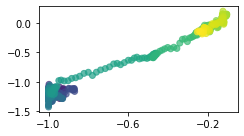

(3, 5)


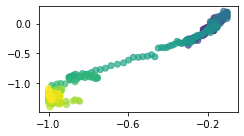

In [ ]:
import matplotlib as mpl

cmap = mpl.colormaps['viridis']

coulmb_co = genfromtxt('datasets/traj-mda.csv', delimiter=',')
# rels_co = np.array((contr[(2,4)], contr[(1,3)]))
other_mode =    'lennard jones' # 'distance' #

for edge in interesting_edges:
    rel = contr[model_mode][edge][:max_id]
    if other_mode == 'lennard jones':
        other = all_lenjones[edge][:max_id]
    elif other_mode == 'distance':
        other = all_dists[edge][:max_id]
    
#     for coul, rel in zip(coulmb, rels):
    plt.figure(figsize=(3.5,2))
    colors = [cmap(val) for val in np.linspace(0, 1, len(rel))]
    print(edge)
    plt.scatter(other,rel,c=colors, alpha=.7 )
#     plt.xlabel(other_mode)
#     plt.ylabel('contribution')
    plt.xlim(-1.05, -.05)
    plt.xticks([-1, -.6, -.2])
    plt.tight_layout()
    i,j = edge
    # plt.savefig(f'pics/mda_scatter_selected_{query_mode}_contr_{i}-{j}_{mode}_model-{model_mode}.png', transparent=True)
    plt.show()

# Correlation between NODE contr. and len.-jon.

4 O


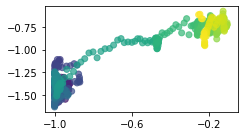

3 O


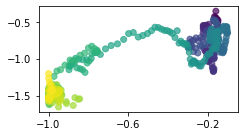

In [ ]:
contr = {}


cmap = mpl.colormaps['viridis']

coulmb_co = genfromtxt('datasets/traj-mda.csv', delimiter=',')
# rels_co = np.array((contr[(2,4)], contr[(1,3)]))
other_mode =    'lennard jones' # 'distance' #

for edge in interesting_edges:
    if other_mode == 'lennard jones':
        other = all_lenjones[edge][:max_id]
    elif other_mode == 'distance':
        other = all_dists[edge][:max_id]
    node,_ = edge
    print(node, atom_names_dict[sample['_atomic_numbers'][node].item()])
    rel = clc_contr[model_mode][node][:max_id]
    

    plt.figure(figsize=(3.5,2))
    colors = [cmap(val) for val in np.linspace(0, 1, len(rel))]
    plt.scatter(other,rel,c=colors, alpha=.7 )
    
#     plt.xlabel(other_mode)
#     plt.ylabel('relevance')
    plt.xlim(-1.05, -.05)
    plt.xticks([-1, -.6, -.2])
    plt.tight_layout()
    plt.tight_layout()
    
#     a1,a2 = atom_names_dict[sample['_atomic_numbers'][i].item()], atom_names_dict[sample['_atomic_numbers'][j].item()]
    # plt.savefig(f'pics/mda_scatter_selected_{query_mode}_contr_{node}_{mode}_model-{model_mode}.png', transparent=True)
    plt.show()

In [ ]:
from sklearn.metrics import r2_score

for edge in interesting_edges:
    
    rel,lenjon, dists = contr[model_mode][edge][:max_id], all_lenjones[edge][:max_id], all_dists[edge][:max_id]
    
    r2_lenjon = r2_score(rel, lenjon)
    r2_r = r2_score(rel, dists)
    
    print('for edge ', edge)
    print(f"R^2 value for Lennard-Jones: {r2_lenjon:.2f}")
    print(f"R^2 value for R: {r2_r:.2f}")
    print('')

for edge  (4, 5)
R^2 value for Lennard-Jones: 0.86
R^2 value for R: -13.20

for edge  (3, 5)
R^2 value for Lennard-Jones: 0.88
R^2 value for R: -10.67

